In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")

In [3]:
import McExperiment
from McExperiment import *
import importlib
importlib.reload(McExperiment)

<module 'McExperiment' from '/Users/silsilviaaa/Desktop/FIN535/final/FIN535-Final-23F/McExperiment.py'>

In [4]:
data = pd.read_csv('data.csv')
data['month'] = data['month'].apply(lambda x: datetime.strptime(x, '%Y-%m')) #assume each date per month is the last day
data.set_index(['month'],inplace=True)

In [4]:
# read in optimal allocation from excel 
def read_condo_rst(n_strat=4):
    # return a table, row = objective, col = optimal allocation, and some critical stats
    ratios = []
    objs = []
    for i in range(n_strat): # for each objective, which corresponds to each sheet
        objs += [list(pd.read_excel('final sheet.xlsx', sheet_name=i).iloc[[11,13,15,17,19],8].values.astype('f'))]
        ratio = list(pd.read_excel('final sheet.xlsx', sheet_name=i).iloc[2,7:12].values.astype('f'))
        ratio[4] *= -1
        ratios += [ratio]
    opt_ratios = pd.DataFrame(ratios, index = ['max uti','max sharpe','max sortino','min mdd'], 
                  columns=['x1','x2','x3','x4','x5'])
    opt_objs = pd.DataFrame(objs, index = ['max uti','max sharpe','max sortino','min mdd'],\
                        columns = ['sharpe','mdd','uti','CE','sortino'])
    return pd.concat([opt_ratios, opt_objs],axis = 1)

n_strat=4
opt_excel_soln = read_condo_rst(n_strat)
opt_excel_soln

,x1,x2,x3,x4,x5,sharpe,mdd,uti,CE,sortino
max uti,0.181262,1.024393,0.750000,0.75,-0.205655,1.097224,0.250001,0.006363,12.076599,1.583711
max sharpe,0.490185,0.509815,0.342315,0.75,-0.000000,1.552223,0.250000,0.005783,12.069595,2.142872
max sortino,0.484227,0.515773,0.356543,0.75,-0.000000,1.551894,0.250000,0.005807,12.069884,2.143256
min mdd,0.463338,0.536662,0.280175,0.75,-0.000000,1.510296,0.196292,0.005592,12.067296,2.096605


In [5]:
# Read ratios from grid search 
with open('storage cache/df_results.pkl', 'rb') as file:
    grid_ratios = pickle.load(file)

#### Note:

excel results are quite different from the sim results because:
- sim is not a good method and has many cons
- max uti in sim result is max(cap after tax), excel is max mean(each log(1+simple return))
- sim result's sharpe and sortino did not minus risk-free in the numerator
- 

### Add bench and initilize + Run results

In [6]:
bench_ratio = pd.DataFrame(np.array([[0.6,0.4,0,0,0], [0.7,0.3,0,0,0], [0.5,0.5,0,0,0]]),\
    columns = ['x1','x2','x3','x4','x5'], index = ['bench6/4','bench7/3','bench5/5'])

ratios = pd.concat([bench_ratio,opt_excel_soln.iloc[np.r_[0,2:4],:5],\
    grid_ratios.iloc[np.r_[0,2:5],:]], axis = 0)

In [17]:
# Only keep the max sortino (drop max sharpe)
ratios.index

Index(['bench6/4', 'bench7/3', 'bench5/5', 'max uti', 'max sortino', 'min mdd',
       'uti', 'sortino', 'mdd', 'prob'],
      dtype='object')

In [8]:
condo_rst = dict()
condo_rst['ratios'] = ratios
condo_rst['Simu_table'] = [] # simulated results before taking the avg
condo_rst['Cap_table'] = [] # for the financial diamond construction
condo_rst['Summary_table'] = [] # after taking the avg of simulated results, then compute some critical stats


In [9]:
SAVE = 40000
CAP = 50000
g = 0.11
MC = 500
path_length = 120 # 10 year
tax_rate = 0.25


for i in tqdm(range(len(ratios))):
    ratio = (ratios.iloc[i,:]).to_list()
    # Get the analysis for end of 5Y/7Y/9Y 
    Simu_table, Simu_cap_table = Experiments(MC,path_length,data,CAP,SAVE,g,ratio,years=[60,84,120],tax=tax_rate)
    Summary_table, cap_table = GetSummary(Simu_table, Simu_cap_table, path_length)
    Summary_table = Summary_table.fillna(0)
    condo_rst['Simu_table'].append(Simu_table)
    condo_rst['Cap_table'].append(cap_table)
    condo_rst['Summary_table'].append(Summary_table)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [01:29<00:00,  8.96s/it]


In [11]:
condo_rst['Summary_table'][0].round(2)

,Expected Cap,Std Cap,Exp Cap < 500k,Prob >= 500k,Expected Annual_sharpe,Expected Annual_sortino,Expected MDD,ret VaR,ret CVaR,cap VaR,cap CVaR
5Y,219358.94,48735.88,219358.94,0.00,1.15,1.57,0.17,0.05,-0.01,-376866.33,-377206.41
7Y,342260.76,59534.28,342260.76,0.00,1.09,1.44,0.21,0.41,0.40,-274310.07,-277385.44
10Y,639982.10,93633.46,450300.43,0.98,1.15,1.51,0.22,1.04,1.02,-60632.05,-62699.33


In [12]:
condo_rst['Summary_table'][3].round(2)

,Expected Cap,Std Cap,Exp Cap < 500k,Prob >= 500k,Expected Annual_sharpe,Expected Annual_sortino,Expected MDD,ret VaR,ret CVaR,cap VaR,cap CVaR
5Y,281591.54,67167.01,281591.54,0.00,1.16,1.68,0.19,0.54,0.54,-354219.65,-356494.30
7Y,460742.01,99235.00,395905.62,0.38,1.13,1.66,0.20,1.27,1.27,-200943.35,-234093.80
10Y,990015.73,196696.72,0.00,1.00,1.19,1.76,0.21,2.63,2.59,164183.03,124667.76


In [13]:
condo_rst['Summary_table'][4].round(2)

,Expected Cap,Std Cap,Exp Cap < 500k,Prob >= 500k,Expected Annual_sharpe,Expected Annual_sortino,Expected MDD,ret VaR,ret CVaR,cap VaR,cap CVaR
5Y,261626.55,64320.20,261626.55,0.00,1.66,2.19,0.13,0.54,0.52,-366646.47,-368852.96
7Y,422230.63,90152.62,380975.03,0.26,1.57,2.09,0.15,1.04,0.95,-227734.63,-238523.40
10Y,888184.30,162990.84,0.00,1.00,1.68,2.30,0.16,2.04,2.02,106387.27,57260.00


In [14]:
condo_rst['Summary_table'][5].round(2)

,Expected Cap,Std Cap,Exp Cap < 500k,Prob >= 500k,Expected Annual_sharpe,Expected Annual_sortino,Expected MDD,ret VaR,ret CVaR,cap VaR,cap CVaR
5Y,257167.30,68183.71,257167.30,0.00,1.61,2.13,0.12,0.56,0.49,-374075.69,-374075.69
7Y,411449.26,98182.63,363236.82,0.27,1.53,2.06,0.14,1.02,0.98,-240420.68,-269592.79
10Y,849692.63,155571.93,0.00,1.00,1.62,2.24,0.14,1.90,1.88,43263.64,39748.03


In [15]:
condo_rst['Summary_table'][6].round(2)

,Expected Cap,Std Cap,Exp Cap < 500k,Prob >= 500k,Expected Annual_sharpe,Expected Annual_sortino,Expected MDD,ret VaR,ret CVaR,cap VaR,cap CVaR
5Y,280140.69,63222.28,280140.69,0.00,1.37,1.87,0.19,0.52,0.52,-341021.98,-345797.84
7Y,484380.93,96144.42,415956.83,0.42,1.37,1.88,0.21,1.60,1.54,-175211.78,-197247.54
10Y,1094716.67,204000.61,0.00,1.00,1.47,2.05,0.22,2.81,2.81,194224.38,179405.26


In [10]:
# with open('storage cache/condo_rst.pkl', 'wb') as file:
#     pickle.dump(condo_rst, file)

### Save the results: Plots and Tables

In [5]:
with open('storage cache/condo_rst.pkl', 'rb') as file:
        condo_rst = pickle.load(file)

In [32]:
# Get stat table:
ptf_name = ['bench6/4', 'bench7/3', 'bench5/5', 'max uti', 'max sortino', 'min mdd',\
    'mc max uti', 'mc max sortino', 'mc min dd','mc max prob']

df_full = pd.concat(condo_rst['Summary_table'])

In [34]:
df_5Y = df_full.loc[df_full.index == '5Y']
indexstr = [sub + ' 5Y' for sub in ptf_name] 
df_5Y.index = indexstr
# df_5Y.to_csv('storage cache/stat_condo_5Y.csv')

In [39]:
df_7Y = df_full.loc[df_full.index == '7Y']
indexstr = [sub + ' 7Y' for sub in ptf_name] 
df_7Y.index = indexstr
# df_7Y.to_csv('storage cache/stat_condo_7Y.csv')

In [40]:
df_10Y = df_full.loc[df_full.index == '10Y']
indexstr = [sub + ' 10Y' for sub in ptf_name] 
df_10Y.index = indexstr
# df_10Y.to_csv('storage cache/stat_condo_10Y.csv')

In [47]:
df_7Y

,Expected Cap,Std Cap,Exp Cap < 500k,Prob >= 500k,Expected Annual_sharpe,Expected Annual_sortino,Expected MDD,ret VaR,ret CVaR,cap VaR,cap CVaR
bench6/4 7Y,342260.756406,59534.275482,342260.756406,0.000,1.093907,1.443509,0.211855,0.408969,0.395303,-274310.068048,-277385.443505
bench7/3 7Y,343613.753821,59617.664025,343613.753821,0.000,1.002619,1.347029,0.267737,0.368036,0.347314,-270888.573833,-274302.719796
bench5/5 7Y,342642.335769,62698.604774,342642.335769,0.000,1.092781,1.418967,0.168798,0.405513,0.398110,-279776.695410,-279890.164790
max uti 7Y,460742.010373,99235.003930,395905.616839,0.380,1.134579,1.661738,0.202262,1.268930,1.266880,-200943.347205,-234093.802850
max sortino 7Y,422230.629249,90152.622280,380975.029558,0.262,1.565236,2.087432,0.153940,1.037285,0.945060,-227734.629684,-238523.397999
min mdd 7Y,411449.260004,98182.626692,363236.820044,0.268,1.533822,2.061597,0.138488,1.017274,0.977283,-240420.678709,-269592.794390
mc max uti 7Y,484380.926729,96144.419480,415956.833726,0.424,1.373603,1.882017,0.211594,1.596046,1.536220,-175211.777103,-197247.543790
mc max sortino 7Y,415029.935096,85257.752881,387783.512702,0.180,1.554042,2.065018,0.186680,1.003168,0.978708,-224596.632007,-265281.814778
mc min dd 7Y,357691.186969,76179.681799,355391.312354,0.012,1.053281,1.509040,0.129999,0.721842,0.692970,-270737.432884,-270737.432884
mc max prob 7Y,394898.462488,91019.307794,362339.127891,0.194,1.161283,1.650670,0.153515,0.976178,0.958772,-252928.875373,-260123.119194


In [45]:
ratios

,x1,x2,x3,x4,x5
bench6/4,0.6,0.4,0.0,0.0,0.0
bench7/3,0.7,0.3,0.0,0.0,0.0
bench5/5,0.5,0.5,0.0,0.0,0.0
max uti,0.181262,1.024393,0.75,0.75,-0.205655
max sortino,0.484227,0.515773,0.356543,0.75,-0.0
min mdd,0.463338,0.536662,0.280175,0.75,-0.0
uti,0.5962732590649619,0.9122335765711901,0.4404862891718153,0.7159900339578056,-0.508506835636152
sortino,0.5644501475362365,0.44682985343413717,0.32973558959023175,0.6867829453005588,-0.011280000970373627
mdd,0.2632361868837034,0.7748056046246182,0.2158668753877403,0.19517770834299852,-0.038041791508321654
prob,0.3486118254906069,0.8302611520488421,0.19303079035108062,0.4527699182105931,-0.17887297753944897


### Histogram of ratios

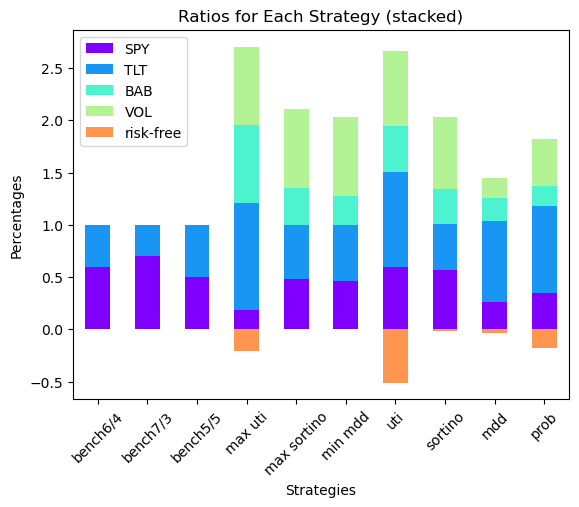

<Figure size 640x480 with 0 Axes>

In [197]:
colors = cm.rainbow(np.linspace(0, 1, 6))
df = condo_rst['ratios']
df=df.astype(float)
df.columns = ['SPY','TLT',"BAB","VOL","risk-free"]
df.plot.bar(stacked=True, rot = 45, color = colors)
plt.xlabel('Strategies')
plt.ylabel('Percentages')
plt.title('Ratios for Each Strategy (stacked)')
# plt.legend(title='Assets', loc='upper left')
plt.show()
plt.savefig('./plots/all_strat_alloc_ratios.png')

<Figure size 1000x600 with 0 Axes>

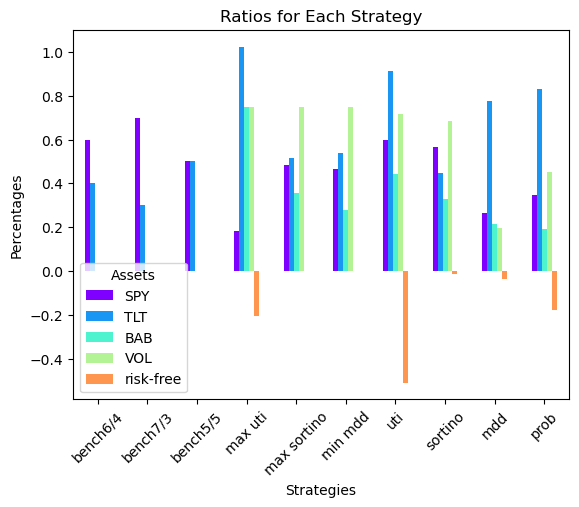

<Figure size 640x480 with 0 Axes>

In [198]:
plt.figure(figsize=(10,6))
df.plot.bar(rot = 45, color = colors)
plt.xlabel('Strategies')
plt.ylabel('Percentages')
plt.title('Ratios for Each Strategy')
plt.legend(title='Assets', loc='lower left')
plt.show()
plt.savefig('./plots/all_strat_alloc_ratios_grouped.png')

### EF plot

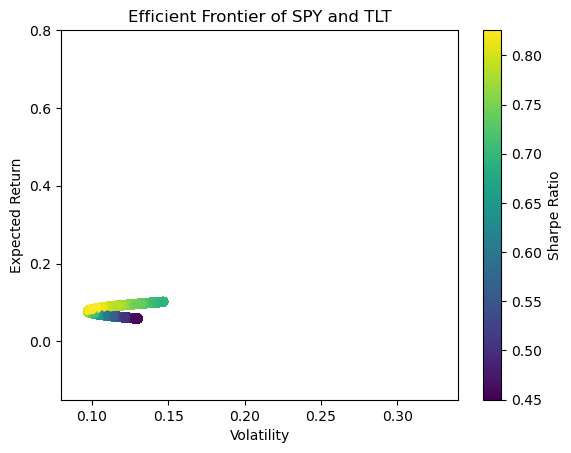

In [143]:
# Example data (replace with your own)
expected_returns = np.array([0.10161837, 0.058552221])
volatilities = np.array([0.146790315,0.130130114])

# Number of random portfolios to generate
num_portfolios = 100000

# Generate random portfolios
np.random.seed(42)
weights = np.random.random((num_portfolios, len(expected_returns)))
weights /= weights.sum(axis=1, keepdims=True)

# Calculate portfolio returns and volatilities
port_returns = np.dot(weights, expected_returns)
port_volatility = np.sqrt(np.dot(weights**2, volatilities**2))

# Plot the random portfolios
plt.scatter(port_volatility, port_returns, c=port_returns/port_volatility, marker='o', cmap='viridis')
plt.title('Efficient Frontier of SPY and TLT')
plt.xlabel('Volatility')
plt.ylabel('Expected Return')
plt.ylim(0.85-1,1.8-1)
plt.xlim(0.08,0.34)
plt.colorbar(label='Sharpe Ratio')
plt.show()

In [202]:
def plot_mu_sig(j):
    cap_input = [238389.2400, 366514.382604, 616558.881595]
    years = [5, 7, 10]
    mu_pts = [condo_rst['Summary_table'][i].iloc[j,0] for i in range(len(condo_rst['Summary_table']))]
    mu_pts = [(mu/cap_input[j]-1)/years[j] for mu in mu_pts]
    sig_pts = [condo_rst['Summary_table'][i].iloc[j,1] for i in range(len(condo_rst['Summary_table']))]
    sig_pts = [sig/cap_input[j]/np.sqrt(years[j]) for sig in sig_pts]
    lab = list(df.index)
    colors = cm.rainbow(np.linspace(0, 1, 10))
    plt.figure(figsize=(8,6))
    for i in range(len(lab)):
        plt.scatter(sig_pts[i],mu_pts[i],label = lab[i], color = colors[i])
    plt.ylim(-0.02,0.08)
    plt.xlim(0.03,0.13)
    plt.title(f'Portfolio return mean v.s. std for each strategy at the end of {years[j]}th year')
    plt.ylabel('Portfolio return mean')
    plt.xlabel('Portfolio return std')
    plt.legend()
    plt.grid()
    plt.show()
    plt.savefig(f'./plots/mu_sig_{years[j]}.png')
    return

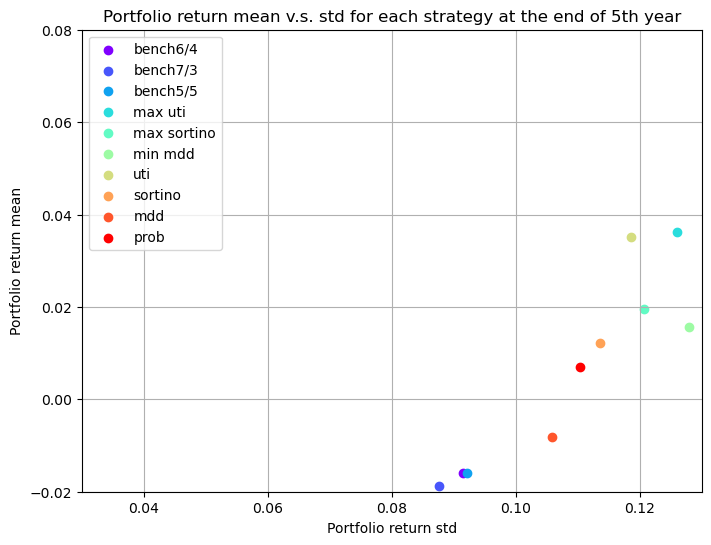

<Figure size 640x480 with 0 Axes>

In [203]:
plot_mu_sig(0)

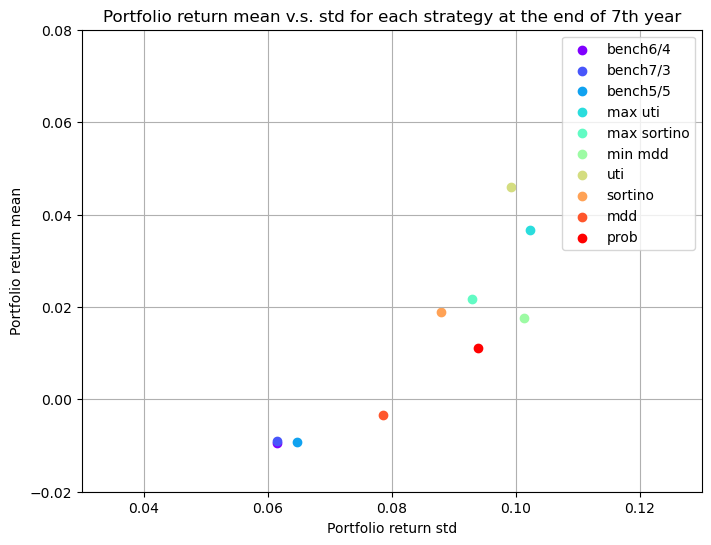

<Figure size 640x480 with 0 Axes>

In [204]:
plot_mu_sig(1)

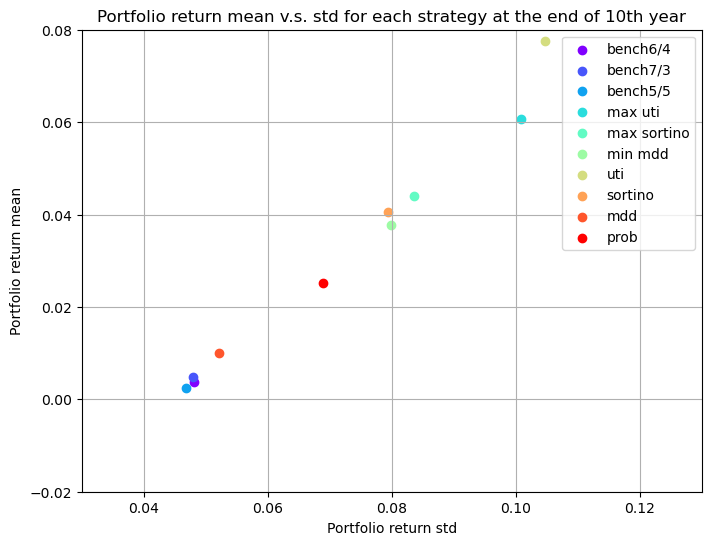

<Figure size 640x480 with 0 Axes>

In [205]:
plot_mu_sig(2)

## Financial Diamond

In [225]:
with open('alloc_car_rst.pkl', 'rb') as file:
    rst = pickle.load(file)
# with open('alloc_rst.pkl', 'rb') as file:
#     rst = pickle.load(file)

In [226]:
def get_loc(year_pts,cap_pts):
    # points coordinates follows the order of left up right down left(the last one is left is just to connect the points to draw a full diamond)
    x_coor = [year_pts[0],year_pts[1],year_pts[2],year_pts[1],year_pts[0]]
    y_coor = [cap_pts[1],cap_pts[2],cap_pts[1],cap_pts[0],cap_pts[1]]
    return x_coor, y_coor

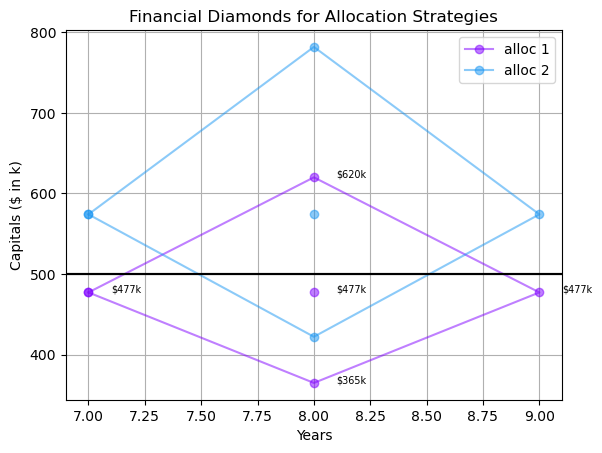

In [230]:

color = iter(cm.rainbow(np.linspace(0, 1, 6)))
labels = ['alloc 1','alloc 2']
fig, ax = plt.subplots()
for i in range(len(cap_pts_lst)):
    c = next(color)
    if i == 1:
        year_pts = [7,8,9]
    else:
        year_pts2 = [6,7,8]
    cap_pts_lst = [[rst['Cap_table'][i].iloc[year_pts[0]-1,0],rst['Cap_table'][i].iloc[year_pts[1]-1,0], rst['Cap_table'][i].iloc[year_pts[2]-1,0]] for i in range(2)] #if my interpretation of the diamond is correct
    x_coor, y_coor = get_loc(year_pts,cap_pts_lst[i])   
    y_coor = [y/1000 for y in y_coor]
    ax.plot(x_coor, y_coor, '-o',alpha = 0.5, label=labels[i],c=c)
    ax.plot(x_coor[1], y_coor[0], '-o',alpha = 0.5,c=c)
    ax.axhline(y=500, c='black')
    for j in range(len(x_coor)-1):
        # TODO: the location of the annotation will need to be changed so that they don't overlap
        if j not in [0,2]:
            ax.annotate(f'${round(y_coor[j])}k', (x_coor[j]+0.1, y_coor[j]-10000*(i)),fontsize=7)
    ax.annotate(f'${round(y_coor[0])}k', (x_coor[1]+0.1, y_coor[0]-10000*(i)),fontsize=7)
ax.legend()
ax.set_title('Financial Diamonds for Allocation Strategies')
ax.set_xlabel('Years')
ax.set_ylabel('Capitals ($ in k)')
ax.grid()
# plt.savefig(f'./plots/fidi_car.png')